# Spatial join

[Spatial join](http://wiki.gis.com/wiki/index.php/Spatial_Join) is
yet another classic GIS problem. Getting attributes from one layer and
transferring them into another layer based on their spatial relationship
is something you most likely need to do on a regular basis.

In the previous section we learned how to perform **a Point in Polygon query**.
We could now apply those techniques and create our own function to perform **a spatial join** between two layers based on their
spatial relationship. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the
attributes of a polygon that ``contains`` the point.

Luckily, [spatial join is already implemented in Geopandas](http://geopandas.org/mergingdata.html#spatial-joins)
, thus we do not need to create it ourselves. There are three possible types of
join that can be applied in spatial join that are determined with ``op`` -parameter in the ``gpd.sjoin()`` -function:

-  ``"intersects"``
-  ``"within"``
-  ``"contains"``

Sounds familiar? Yep, all of those spatial relationships were discussed
in the [Point in Polygon lesson](point-in-polygon.ipynb), thus you should know how they work.

Let's perform a spatial join between these two layers:
- **Addresses:** the address-point Shapefile that we created trough geocoding 
- **Population grid:** a Polygon layer that is a 250m x 250m grid showing the amount of people living in the Helsinki Region.
    - The population grid a dataset is produced by the **Helsinki Region Environmental
Services Authority (HSY)** (see [this page](https://www.hsy.fi/fi/asiantuntijalle/avoindata/Sivut/AvoinData.aspx?dataID=7) to access data from different years).
    - For this lesson we will use the population grid for year 2017, which can be dowloaded as a shapefile [from this link](https://www.hsy.fi/sites/AvoinData/AvoinData/SYT/Tietoyhteistyoyksikko/Shape%20(Esri)/V%C3%A4est%C3%B6tietoruudukko/Vaestotietoruudukko_2017_SHP.zip) in the  [Helsinki Region Infroshare
(HRI) open data portal](https://hri.fi/en_gb/) 


## Download and clean the data

**Execute the following steps in a terminal window**

- Navigate to the data folder

```
    $ cd data
```

- Download the population grid using wget:

```
    $ wget "https://www.hsy.fi/sites/AvoinData/AvoinData/SYT/Tietoyhteistyoyksikko/Shape%20(Esri)/V%C3%A4est%C3%B6tietoruudukko/Vaestotietoruudukko_2017_SHP.zip"

```

-  Unzip the file in Terminal into a folder called Pop17 (using -d flag)

```
    $ unzip Vaestotietoruudukko_2017_SHP.zip -d Pop17

```

You should now have a folder ``/data/Pop17`` containing the population grid shapefile.

-  Let's read the data into memory and see what we have.


In [22]:
import geopandas as gpd

# Filepath
fp = "data/Pop17/Vaestoruudukko_2017.shp"

# Read the data
pop = gpd.read_file(fp)

# See the first rows
pop.head()


INDEX  ASUKKAITA  ASVALJYYS  IKA0_9  IKA10_19  IKA20_29  IKA30_39  \
0    688          9       28.0      99        99        99        99   
1    710          8       44.0      99        99        99        99   
2    711          5       90.0      99        99        99        99   
3    715         12       37.0      99        99        99        99   
4    848          6       44.0      99        99        99        99   

   IKA40_49  IKA50_59  IKA60_69  IKA70_79  IKA_YLI80  \
0        99        99        99        99         99   
1        99        99        99        99         99   
2        99        99        99        99         99   
3        99        99        99        99         99   
4        99        99        99        99         99   

                                            geometry  
0  POLYGON Z ((25472499.99532626 6689749.00506918...  
1  POLYGON Z ((25472499.99532626 6684249.00413040...  
2  POLYGON Z ((25472499.99532626 6683999.00499700...  
3  POLYGON Z ((25472499.99532626 6682998.99846143...  
4  POLYGON Z ((25472749.99291839 6690249.00333598...

Okey so we have multiple columns in the dataset but the most important
one here is the column ``ASUKKAITA`` (*"population" in Finnish*) that
tells the amount of inhabitants living under that polygon.

-  Let's change the name of that columns into ``pop17`` so that it is
   more intuitive. Changing column names is easy in Pandas / Geopandas
   using a function called ``rename()`` where we pass a dictionary to a
   parameter ``columns={'oldname': 'newname'}``.

In [23]:
# Change the name of a column
pop = pop.rename(columns={'ASUKKAITA': 'pop17'})

# See the column names and confirm that we now have a column called 'pop17'
pop.columns

Index(['INDEX', 'pop17', 'ASVALJYYS', 'IKA0_9', 'IKA10_19', 'IKA20_29',
       'IKA30_39', 'IKA40_49', 'IKA50_59', 'IKA60_69', 'IKA70_79', 'IKA_YLI80',
       'geometry'],
      dtype='object')

-  Let's also get rid of all unnecessary columns by selecting only
   columns that we need i.e. ``pop17`` and ``geometry``

In [24]:
# Columns that will be sected
selected_cols = ['pop17', 'geometry']

# Select those columns
pop = pop[selected_cols]

# Let's see the last 2 rows
pop.head()

pop17                                           geometry
0      9  POLYGON Z ((25472499.99532626 6689749.00506918...
1      8  POLYGON Z ((25472499.99532626 6684249.00413040...
2      5  POLYGON Z ((25472499.99532626 6683999.00499700...
3     12  POLYGON Z ((25472499.99532626 6682998.99846143...
4      6  POLYGON Z ((25472749.99291839 6690249.00333598...

Now we have cleaned the data and have only those columns that we need
for our analysis.

## Join the layers

Now we are ready to perform the spatial join between the two layers that
we have. The aim here is to get information about **how many people live
in a polygon that contains an individual address-point** . Thus, we want
to join attributes from the population layer we just modified into the
addresses point layer ``addresses.shp`` that we created trough gecoding in the previous section.

-  Read the addresses layer into memory

In [25]:
# Addresses filpath
addr_fp = r"data/addresses.shp"

# Read data
addresses = gpd.read_file(addr_fp)

# Check the head of the file
addresses.head()

address    id  \
0  Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...  1000   
1  Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...  1001   
2  Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...  1002   
3  1, Hermannin rantatie, Hermanninmäki, Hermanni...  1003   
4  Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...  1005   

                                            addr  \
0       Itämerenkatu 14, 00101 Helsinki, Finland   
1          Kampinkuja 1, 00100 Helsinki, Finland   
2           Kaivokatu 8, 00101 Helsinki, Finland   
3  Hermannin rantatie 1, 00580 Helsinki, Finland   
4     Tyynenmerenkatu 9, 00220 Helsinki, Finland   

                        geometry  
0  POINT (24.9155624 60.1632015)  
1  POINT (24.9316914 60.1690222)  
2  POINT (24.9416849 60.1699637)  
3  POINT (24.9655355 60.2008878)  
4  POINT (24.9216003 60.1566475)

In order to do a spatial join, the layers need to be in the same projection

In [26]:
# Are the layers in the same projection?
addresses.crs == pop.crs

False

Let's re-project addresses to the projection of the population layer:

In [27]:
addresses = addresses.to_crs(pop.crs)

-  Let's make sure that the coordinate reference system of the layers
are identical

In [28]:
# Check the crs of address points
print(addresses.crs)

# Check the crs of population layer
print(pop.crs)

# Do they match now?
addresses.crs == pop.crs

{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 25, 'k': 1, 'x_0': 25500000, 'y_0': 0, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}
{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 25, 'k': 1, 'x_0': 25500000, 'y_0': 0, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


True

Now they should be identical. Thus, we can be sure that when doing spatial
queries between layers the locations match and we get the right results
e.g. from the spatial join that we are conducting here.

-  Let's now join the attributes from ``pop`` GeoDataFrame into
   ``addresses`` GeoDataFrame by using ``gpd.sjoin()`` -function

In [29]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how="inner", op="within")

# Let's check the result
join.head()

address    id  \
0   Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...  1000   
1   Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...  1001   
2   Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...  1002   
10  Rautatientori, Keskusta, Kluuvi, Eteläinen suu...  1011   
3   1, Hermannin rantatie, Hermanninmäki, Hermanni...  1003   

                                             addr  \
0        Itämerenkatu 14, 00101 Helsinki, Finland   
1           Kampinkuja 1, 00100 Helsinki, Finland   
2            Kaivokatu 8, 00101 Helsinki, Finland   
10       Rautatientori 1, 00100 Helsinki, Finland   
3   Hermannin rantatie 1, 00580 Helsinki, Finland   

                                       geometry  index_right  pop17  
0   POINT (25495311.60802662 6672258.694634228)         3238    501  
1   POINT (25496207.84010911 6672906.172794735)         3350    190  
2   POINT (25496762.72293893 6673010.538330208)         3474     37  
10  POINT (25496896.60078502 6673159.446016792)         3474     37  
3   POINT (25498088.55200266 6676455.030033929)         3711    133

Awesome! Now we have performed a successful spatial join where we got
two new columns into our ``join`` GeoDataFrame, i.e. ``index_right``
that tells the index of the matching polygon in the population grid and
``pop17`` which is the population in the cell where the address-point is
located.

-  Let's save this layer into a new Shapefile

In [30]:
# Output path
outfp = r"data/addresses_pop17_epsg3979.shp"

# Save to disk
join.to_file(outfp)

Do the results make sense? Let's evaluate this a bit by plotting the
points where color intensity indicates the population numbers.

-  Plot the points and use the ``pop17`` column to indicate the color.
   ``cmap`` -parameter tells to use a sequential colormap for the
   values, ``markersize`` adjusts the size of a point, ``scheme`` parameter can be used to adjust the classification method based on [pysal](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html), and ``legend`` tells that we want to have a legend.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


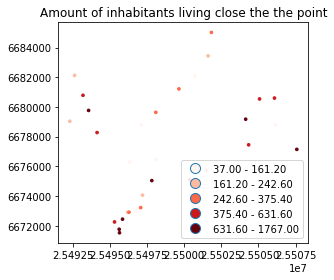

In [31]:
import matplotlib.pyplot as plt

# Plot the points with population info
join.plot(column='pop17', cmap="Reds", markersize=7, scheme='quantiles', legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

By knowing approximately how population is distributed in Helsinki, it
seems that the results do make sense as the points with highest
population are located in the south where the city center of Helsinki
is.